In [865]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multinomial
from scipy.stats import gamma
from scipy.stats import invgamma
import math
from scipy.special import beta
from scipy.integrate import quad
from scipy.stats import beta as beta_dist

In [866]:
def beta_k(x,mu,tao,T): # beta distribution on [0,T]
    result= x**(mu*tao/T-1)*(T-x)**(tao*(1-mu/T)-1)/beta(mu*tao/T,tao*(1-mu/T))/T**(tao-1)
    return result

## simulation

In [867]:
T=100

In [868]:
x=np.linspace(0+T/1000/2,T-T/1000/2,1000)

In [870]:
intensity=np.zeros(1000)

In [871]:
for i in range(1000):
    intensity[i]=(0.3*beta_k(x[i],20,50,T)+0.3*beta_k(x[i],50,50,T)+0.4*beta_k(x[i],80,50,T))*200 ## 3 components, [20,50][50,50][80,50],gamma=200

In [872]:
def inhomo_simulation(measure,delta_t,measure_sup,T):
    t=0
    points_homo=[]
    points_inhomo=[]
    while(t<T):
        points_homo.append(t)
        r=expon.rvs(scale=1/measure_sup) #scale=1/lamda
        t+=r
        if t>=T: break
        D=uniform.rvs(loc=0,scale=1)
        if D*measure_sup<=measure[int(t/delta_t)]:
            points_inhomo.append(t)
    if points_inhomo[-1]>T:
        del points_inhomo[-1]
    del points_homo[0]
    return points_inhomo

In [873]:
points_inhomo=inhomo_simulation(intensity,T/len(x),max(intensity),T)

In [874]:
len(points_inhomo)

226

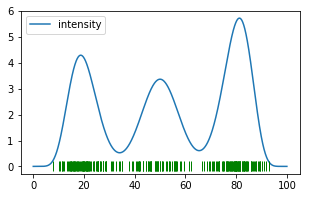

In [875]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(x,intensity,label='intensity')
axs.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
plt.legend()
plt.show()

## inference

In [766]:
gamma_posterior=gamma(a=len(points_inhomo),scale=1).rvs()

## posterior of $\theta$

In [767]:
alpha=0.5             ## DP prior and initialization

mu=50.0

tao=50.0

In [768]:
N=len(points_inhomo)   ## mcmc initialization

C=np.zeros(N,dtype=int)

Phi=np.array([[mu,tao]])

In [769]:
C_list=[]
phi_list=[]

In [770]:
for m in range(500):
    ## sample clusters:

    for i in range(N):
        mu_old,tao_old=Phi[C[i]]
        C_old=C
        Phi_old=Phi

        if sum(C==C[i])==1: # i is a singlton, delete phi_ci,delete ci, all the c>c_i--1
            Phi=np.delete(Phi,C[i],axis=0)
            C=C-(C>C[i])
            C=np.delete(C,i)
        else:               # i not a singlton, just delete c_i
            C=np.delete(C,i)
        clusters=np.unique(C)
#         print(clusters)
        assert clusters[0]==0
        prob=[sum(C==j)/(N-1+alpha) for j in clusters]
        prob.append(alpha/(N-1+alpha))
        assert sum([sum(C==j) for j in clusters])==N-1, print(sum([sum(C==j) for j in clusters]),N-1)
        c_proposal=multinomial(n=1,p=prob).rvs()[0].tolist().index(1)
#         print(c_proposal)
        if c_proposal==len(clusters):  ## propose a new cluster
            assert c_proposal==clusters[-1]+1
            mu_proposal=uniform(0,T).rvs()
            tao_proposal=invgamma(a=25,scale=1250).rvs()  # propose a new \theta
            accep_rate=min(beta_k(points_inhomo[i],mu_proposal,tao_proposal,T)/beta_k(points_inhomo[i],mu_old,tao_old,T),1)
            temp=uniform(0,1).rvs()
            if temp<accep_rate:
                C=np.insert(C,i,max(C)+1)
                Phi=np.append(Phi,[[mu_proposal,tao_proposal]],axis=0)
#                 print(Phi)
            else:
                C=C_old
                Phi=Phi_old
        else:                          ## propose a old cluster
            mu_proposal=Phi[clusters[c_proposal]][0]
            tao_proposal=Phi[clusters[c_proposal]][1]
            accep_rate=min(beta_k(points_inhomo[i],mu_proposal,tao_proposal,T)/beta_k(points_inhomo[i],mu_old,tao_old,T),1)
            temp=uniform(0,1).rvs()
            if temp<accep_rate:
                C=np.insert(C,i,c_proposal)
            else:
                C=C_old
                Phi=Phi_old

    C_list.append(C)
    
    # sample \phi
    for i in C:
        data=np.array(points_inhomo)[C==i]
        mu_proposal=uniform(0,T).rvs()
        tao_proposal=invgamma(a=25,scale=1250).rvs()  # propose a new \theta
        accep_rate=0
        for j in range(len(data)):
            accep_rate+=np.log(beta_k(data[j],mu_proposal,tao_proposal,T))-np.log(beta_k(data[j],Phi[i][0],Phi[i][1],T))
        accep_rate=min(np.exp(accep_rate),1)
        temp=uniform(0,1).rvs()
        if temp<accep_rate:
            Phi[i]=[mu_proposal,tao_proposal]
    
    phi_list.append(Phi)

In [771]:
np.unique(C_list[-1])

array([0, 1, 2, 3])

In [772]:
phi_list[-1]

array([[79.29133079, 40.61544178],
       [19.57668676, 47.83714899],
       [49.98548199, 62.54969512],
       [48.11397141, 60.90475906]])

In [781]:
pro=[sum(C_list[-1]==i)/(N+alpha) for i in np.unique(C_list[-1])]

In [782]:
pro.append(alpha/(alpha+N))

## assume 100 $\theta$ on the truncated G

In [838]:
theta_G=[]

In [840]:
J=1000

In [841]:
for i in range(J):
    index=multinomial(n=1,p=pro).rvs()[0].tolist().index(1)
    if index==len(phi_list[-1]):
        theta_G.append([uniform(0,T).rvs(),invgamma(a=25,scale=1250).rvs()])  # propose a new \theta
    else:
        theta_G.append(phi_list[-1][index])

In [842]:
theta_G=np.array(theta_G)

In [846]:
z=np.zeros(J)
weight_G=np.zeros(J)
z[0]=beta_dist(a=1,b=alpha+N).rvs()
weight_G[0]=z[0]
for i in range(1,J-1):
    z[i]=beta_dist(a=1,b=alpha+N).rvs()
    weight_G[i]=z[i]
    for j in range(i):
        weight_G[i]=weight_G[i]*(1-z[j])
weight_G[J-1]=1-sum(weight_G)

In [854]:
def predictive_intensity(x,theta_G,weight_G):
    assert len(theta_G)==len(weight_G)
    J=len(theta_G)
    result=0
    for i in range(J):
        result+=weight_G[i]*beta_k(x,theta_G[i][0],theta_G[i][1],T)
    return result

In [880]:
y_predict=np.array([predictive_intensity(x_i,theta_G,weight_G) for x_i in x])*gamma_posterior

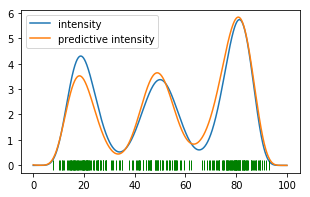

In [881]:
plt.figure(1,figsize=(5,3))
axs=plt.subplot(111)
axs.plot(x,intensity,label='intensity')
axs.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='g', markersize=10)
axs.plot(x,y_predict,label='predictive intensity')
plt.legend()
plt.show()